# Сегментация клиентской базы телекоммуникационной компании

**Цель** — провести анализ данных с целью выделения наиболее типичных групп клиентов и разработки предложений для каждой из групп.

## Примерный план

**Шаг 1.** Загрузка данных;

**Шаг 2.** Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

**Шаг 3.** Добавление новых переменных:
- по признаку `Возраст` ввести новую переменную `Возрастная категория`, принимающую значения: "студент", "аспирант", "бизнесмен" и "знаток" по следующую правилу:

$$
\text{Возрастная категория} =
\left\{
\begin{array}{l}
\text{студент,} \quad \text{если Возраст } \in [19, 24];\\  
\text{аспирант,} \quad \text{если Возраст } \in [25, 33];\\
\text{бизнесмен,} \quad \text{если Возраст } \in [34, 56];\\
\text{знаток,} \quad \text{если Возраст } \in [57, 70].
\end{array}
\right.
$$

- по значениям `Дата подключения тарифа` добавить признаки: `Год подключения`, `Месяц подключения`, `Дата подключения`;  

**Шаг 4.** Провести исследовательский анализ данных:
- в разрезе значений признаков `Год подключения`, `Месяц подключения`, `Дата подключения` исследовать:
    - динамику подключения к тарифам (количество клиентов).
- в разрезе значений признака `Возрастная категория` исследовать распределение признаков `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`.

- с помощью диаграмм рассеивания исследовать зависимости между признаками `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`.

# Подключение библиотек

In [1]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from scipy.stats import (shapiro, kstest,
                         ks_2samp, anderson,
                         jarque_bera,
                         ttest_ind,
                         mannwhitneyu,
                         kruskal)


# Блок пользовательских функций


In [2]:
def delete_apost(x: pd.Series) -> float:
  """
  Функция для корректировки значений признаков, содержащих апострофы.

  Args:
  x -- pd.Series -- столбец DataFrame

  Return:
  возвращает для каждого значения столбца его веществвенное представление.
  """
  if x.isdigit():
      return float(x)
  else:
      return float(x.replace("'", ""))

In [3]:
def calc_boxplot(df_col : pd.Series) -> tuple:

    """
    Функция для расчета значений нижнего и верхнего усов.
    На вход подается столбец датафрейма,
    на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
    """

    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

In [4]:
def get_status(x) ->str:
  """
  Функция для присвоения статуса клиентам.
  На вход подается столбец DataFrame,
  на выходе возвращается строка с соответствующим значением.
  """
  if (x>=19) & (x<=24):
      return 'студент'
  elif (x>=25) & (x<=33):
      return 'аспирант'
  elif (x>=34) & (x<=56):
      return 'бизнесмен'
  elif (x>=57) & (x<=70):
      return 'знаток'

In [5]:
def check_hyp(x, alpha:float=0.05):
  """
  Функция для проверки нормальности распределения значений.
  на вход подается значение переменной x и уровень значимости alpha,
  на выходе получаем вывод о том, принимаем или отвергаем сформулированную
  гипотезу.
  """
  stat_emp, p_value = shapiro(x, nan_policy='omit')
  print('Критерий Шапиро')
  if p_value < alpha:
      print(f"""Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = {p_value}""")
  else:
      print(f"""Гипотезу H_0 о нормальном распределении x примимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = {p_value}""")

In [6]:
def check_ks(x, alpha:float=0.05):
  """
  Функция для проверки различий между распределениями -- выборка против
  теоретического закона.
  на вход подается значение переменной x и уровень значимости alpha,
  на выходе получаем вывод о том, принимаем или отвергаем сформулированную
  гипотезу.
  """
  stat_emp, p_value = kstest(x,
                               cdf=(x.mean(), x.std()),
                               nan_policy='omit'
                               )
  print('Критерий Колмогорова-Смирнова')
  if p_value < alpha:
      print(f"""Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = {p_value}""")
  else:
      print(f"""Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = {p_value}""")

In [7]:
def check_ttest(x,y, alpha:float=0.05):
  """
  Функция для проверки основной гипотезы.
  на вход подаются значения переменных x и y, уровень значимости alpha,
  на выходе получаем вывод о том, принимаем или отвергаем сформулированную
  гипотезу.
  """
  t_statistic, p_value = kstest(x,y,
                               alternative='two-sided',
                               nan_policy='omit'
                               )

  print(f"Статистика t-теста: {t_statistic}")
  print(f"P-значение: {p_value}")
  print('Критерий Стъюдента')
  if p_value < alpha:
      print(f"""Различия статистически значимы (принимаем альтернативную гипотезу):
      <<<клиенты кластера 3, имеют статистически значимые различия
      с клиентами кластера 4 в потреблении услуг связи>>>
        p-value = {p_value}""")
  else:
      print(f"""Различия статистически незначимы (принимаем нулевую гипотезу):
      <<<клиенты кластера 3, не имеют статистически значимых различий
      с клиентами кластера 4 в потреблении услуг связи>>>.
        p-value = {p_value}""")

# Загрузка данных

In [8]:
df = pd.read_csv('/content/sample_data/dataset_telecom.csv')

In [9]:
# просмотр инф-ии о типах данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Возраст                                4492 non-null   int64  
 1   Среднемесячный расход                  4468 non-null   float64
 2   Средняя продолжительность разговоров   4475 non-null   float64
 3   Звонков днем за месяц                  4472 non-null   float64
 4   Звонков вечером за месяц               4489 non-null   float64
 5   Звонков ночью за месяц                 4492 non-null   object 
 6   Звонки в другие города                 4492 non-null   object 
 7   Звонки в другие страны                 4492 non-null   int64  
 8   Доля звонков на стационарные телефоны  4492 non-null   object 
 9   Количество SMS за месяц                4492 non-null   object 
 10  Дата подключения тарифа                4492 non-null   object 
dtypes: f

In [10]:
# просмотр описательных статистик

perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

df.describe(percentiles=perc)

Возраст  Среднемесячный расход  \
count  4492.000000            4468.000000   
mean     41.894924             505.533577   
std      13.077254             646.354693   
min      19.000000               3.180000   
1%       19.000000               7.790100   
5%       20.000000              16.800000   
25%      31.000000             152.490000   
50%      43.000000             315.510000   
75%      52.000000             599.840000   
95%      63.000000            1610.304500   
99%      69.000000            3544.902900   
max      70.000000            5142.760000   

       Средняя продолжительность разговоров  Звонков днем за месяц  \
count                           4475.000000            4472.000000   
mean                               4.230827              63.899374   
std                                3.005210              62.877394   
min                                0.100000               1.000000   
1%                                 0.400000               2.000000   
5%                                 1.100000               5.000000   
25%                                2.100000              37.000000   
50%                                3.300000              53.000000   
75%                                5.900000              68.000000   
95%                                9.700000             133.000000   
99%                               14.452000             391.160000   
max                               20.000000             500.000000   

       Звонков вечером за месяц  Звонки в другие страны  
count               4489.000000             4492.000000  
mean                  70.363778                0.394034  
std                   41.219909                1.171980  
min                    1.000000                0.000000  
1%                     2.000000                0.000000  
5%                     4.000000                0.000000  
25%                   42.000000                0.000000  
50%                   71.000000                0.000000  
75%                   98.000000                0.000000  
95%                  142.000000                2.000000  
99%                  156.000000                6.000000  
max                  160.000000               12.000000

## Выводы
- данные загружены корректно;
- обнаружены следующие особенности данных:

|Признак|Комментарий|
|--:|:--|
|'all'|сделать лаконичные заголовки|
|'Звонков ночью за месяц', 'Звонки в другие города', 'Доля звонков на стационарные телефоны', 'Количество SMS за месяц', 'Дата подключения тарифа'|необходимо скорректировать тип данных|
|"Среднемесячный расход", 'Средняя продолжительность разговоров', 'Звонков днем за месяц', 'Звонков вечером за месяц'|имеются пропуски|
|"Среднемесячный расход", "Звонков днем за месяц"|в ряде признаков есть аномальные значения|
|"Звонки в другие страны"|значительное кол-во клиентов не пользуется услугами данного вида связи|
||возможно следует этих клиентов выделить отдельно|

# Предварительная обработка данных

## Корректировка заголовков

In [11]:
new_columns = {'Возраст': 'возраст',
              'Среднемесячный расход': 'среднемесячный расход',
              'Средняя продолжительность разговоров': 'средняя продолжительность разговоров',
              'Звонков днем за месяц': 'звонки днем',
              'Звонков вечером за месяц': 'звонков вечером',
              'Звонков ночью за месяц': 'звонков ночью',
              'Звонки в другие города': 'звонки в другие города',
              'Звонки в другие страны': 'звонки в другие страны',
              'Доля звонков на стационарные телефоны': 'доля звонков на стационарные телефоны',
              'Количество SMS за месяц': 'количество смс',
              'Дата подключения тарифа': 'дата подключения'}
df.rename(columns=new_columns, inplace=True)

## Корректировка типов данных

In [12]:
# корректировка признака, содержащего дату и время
df = df.astype({'дата подключения': 'datetime64[s]'})

# проверка типов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype        
---  ------                                 --------------  -----        
 0   возраст                                4492 non-null   int64        
 1   среднемесячный расход                  4468 non-null   float64      
 2   средняя продолжительность разговоров   4475 non-null   float64      
 3   звонки днем                            4472 non-null   float64      
 4   звонков вечером                        4489 non-null   float64      
 5   звонков ночью                          4492 non-null   object       
 6   звонки в другие города                 4492 non-null   object       
 7   звонки в другие страны                 4492 non-null   int64        
 8   доля звонков на стационарные телефоны  4492 non-null   object       
 9   количество смс                         4492 non-null   object       
 10  

In [13]:
# список признаков, значения которых содержат ошибки
lst_columns = ['звонков ночью', 'звонки в другие города',
               'доля звонков на стационарные телефоны',
               'количество смс']

for col in lst_columns:
    df[col] = df[col].apply(delete_apost)

# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype        
---  ------                                 --------------  -----        
 0   возраст                                4492 non-null   int64        
 1   среднемесячный расход                  4468 non-null   float64      
 2   средняя продолжительность разговоров   4475 non-null   float64      
 3   звонки днем                            4472 non-null   float64      
 4   звонков вечером                        4489 non-null   float64      
 5   звонков ночью                          4492 non-null   float64      
 6   звонки в другие города                 4492 non-null   float64      
 7   звонки в другие страны                 4492 non-null   int64        
 8   доля звонков на стационарные телефоны  4492 non-null   float64      
 9   количество смс                         4492 non-null   float64      
 10  

## Поиск и обработка дублирующихся записей

In [14]:
print(f'В анализируемом наборе {df.duplicated().sum()} дублей.')

В анализируемом наборе 0 дублей.


## Поиск и обработка аномальных значений

In [15]:
# список непрерывных признаков
lst_var_cont = ['возраст', 'среднемесячный расход',
       'средняя продолжительность разговоров', 'звонки днем', 'звонков вечером',
       'звонков ночью', 'звонки в другие города', 'звонки в другие страны',
       'доля звонков на стационарные телефоны', 'количество смс']

# для выявления аномальных значений признаков построим
# диаграмму "ящик с усами" и гистограмму


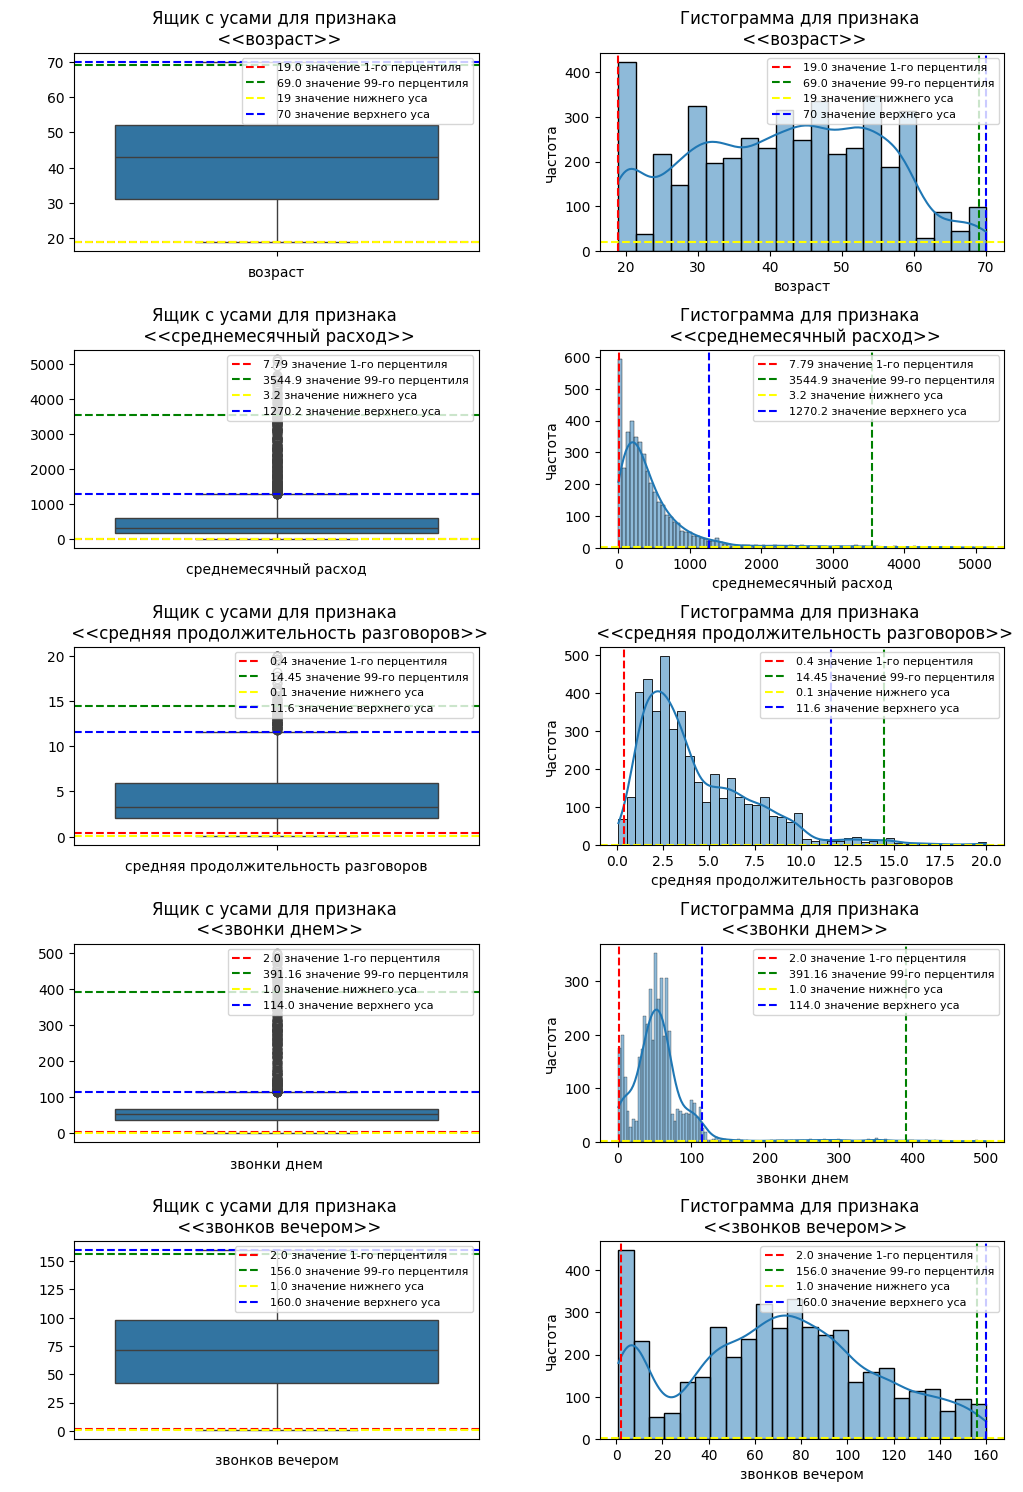

In [16]:
# построим графики циклически для первых 5 признаков
plt.subplots(5,2, figsize=(12,18), gridspec_kw={'wspace': 0.3,
                                                'hspace': 0.5})

for index, col in enumerate(lst_var_cont[:5]):

  per_1 = (np.nanpercentile(df[col], 1)).round(2)
  per_99 = (np.nanpercentile(df[col], 99)).round(2)
  low_wish, hi_wish = calc_boxplot(df[col])

  # boxplot
  plt.subplot(5,2, 2*index+1)
  ax1 = sns.boxplot(df[col]);
  plt.xlabel(f'{col}')
  plt.ylabel(' ')
  plt.title(f'Ящик с усами для признака \n <<{col}>>')

  # визуализация перцентелей
  ax1.axhline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
  ax1.axhline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')

  # визуализация усов
  ax1.axhline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
  ax1.axhline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')
  plt.legend(fontsize=8, loc=1)


  # гистограмма
  plt.subplot(5,2, 2*index+2)
  ax2 = sns.histplot(df[col], kde=True)

  plt.title(f'Гистограмма для признака \n <<{col}>>')
  plt.xlabel(f'{col}')
  plt.ylabel('Частота')

  # визуализация перцентелей
  ax2.axvline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
  ax2.axvline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')
  # визуализация усов
  ax2.axhline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
  ax2.axvline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')


  plt.legend(fontsize=8, loc=1)


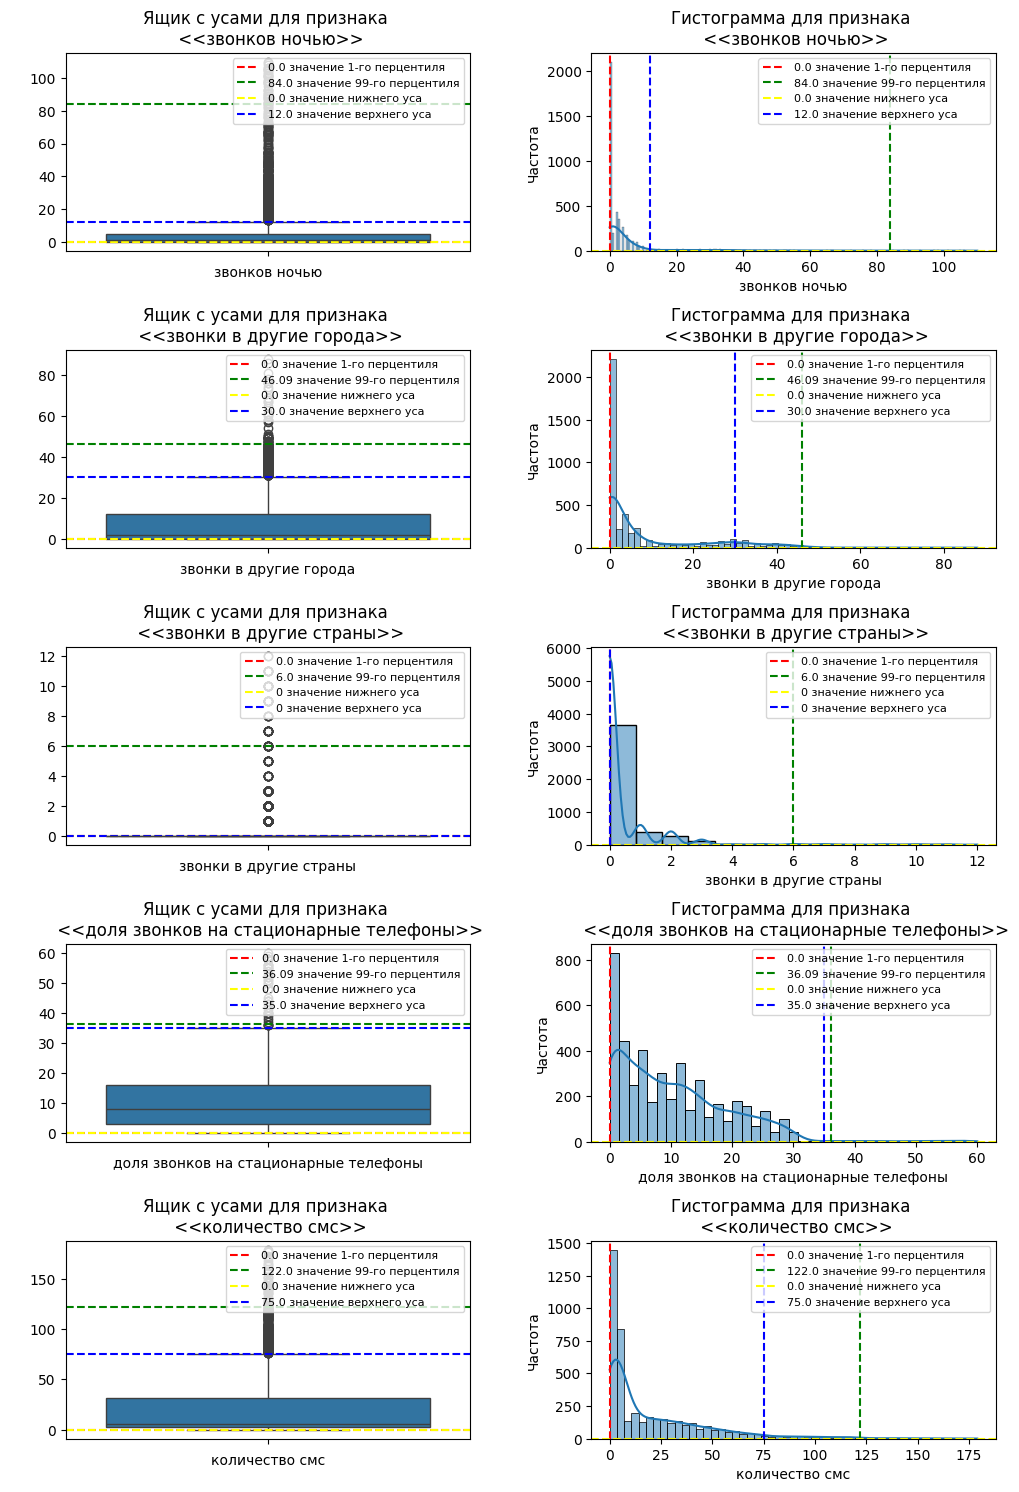

In [17]:
# построим графики циклически для оставшихся 5 признаков
plt.subplots(5,2, figsize=(12,18), gridspec_kw={'wspace': 0.3,
                                                'hspace': 0.5})

for index, col in enumerate(lst_var_cont[5:]):

  per_1 = (np.nanpercentile(df[col], 1)).round(2)
  per_99 = (np.nanpercentile(df[col], 99)).round(2)
  low_wish, hi_wish = calc_boxplot(df[col])

  # boxplot
  plt.subplot(5,2, 2*index+1)
  ax1 = sns.boxplot(df[col]);
  plt.xlabel(f'{col}')
  plt.ylabel(' ')
  plt.title(f'Ящик с усами для признака \n <<{col}>>')

  # визуализация перцентелей
  ax1.axhline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
  ax1.axhline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')

  # визуализация усов
  ax1.axhline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
  ax1.axhline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')
  plt.legend(fontsize=8, loc=1)


  # гистограмма
  plt.subplot(5,2, 2*index+2)
  ax2 = sns.histplot(df[col], kde=True)

  plt.title(f'Гистограмма для признака \n <<{col}>>')
  plt.xlabel(f'{col}')
  plt.ylabel('Частота')

  # визуализация перцентелей
  ax2.axvline(per_1, color='red',
                      linestyle='dashed',
                      label=f'{per_1} значение 1-го перцентиля')
  ax2.axvline(per_99,
              color='green',
              linestyle='dashed',
              label=f'{per_99} значение 99-го перцентиля')
  # визуализация усов
  ax2.axhline(low_wish,
              color='yellow',
              linestyle='dashed',
              label=f'{np.round(low_wish,1)} значение нижнего уса')
  ax2.axvline(hi_wish,
              color='blue',
              linestyle='dashed',
              label=f'{np.round(hi_wish,1)} значение верхнего уса')


  plt.legend(fontsize=8, loc=1)

In [18]:
# проанализировав построенные графики, составим фильтр для отсечения
# аномальный значений.

# В данном случае аномалии удаляться не будут, а далее исследуются отдельно.
# В отдельный набор также будут выделены клиенты, пользующиеся услугами
# международной связи.

# фильтр для значений, не являющимися аномальными
filt = (
(df['среднемесячный расход'].between(calc_boxplot(df['среднемесячный расход'])[0],
                                  calc_boxplot(df['среднемесячный расход'])[1]))
&
(df['средняя продолжительность разговоров']
           .between(calc_boxplot(df['средняя продолжительность разговоров'])[0],
           np.nanpercentile(df['средняя продолжительность разговоров'] ,99)))

&
(df['звонки днем'].between(calc_boxplot(df['звонки днем'])[0],
                  calc_boxplot(df['звонки днем'])[1]))
&

(df['звонки в другие города'].between(calc_boxplot(df['звонки в другие города'])[0],
                            np.nanpercentile(df['звонки в другие города'], 99)))

&

(df['доля звонков на стационарные телефоны']
          .between(calc_boxplot(df['доля звонков на стационарные телефоны'])[0],
          np.nanpercentile(df['доля звонков на стационарные телефоны'], 99)))

&
(df['количество смс'].between(calc_boxplot(df['количество смс'])[0],
                             calc_boxplot(df['количество смс'])[1]))
&
(df['звонков ночью'].between(calc_boxplot(df['звонков ночью'])[0],
                            calc_boxplot(df['звонков ночью'])[1])))

In [19]:
# оценим процент потерь

print(f'% аномальных записей {(1 - df.loc[filt].shape[0]/df.shape[0]):.2%}')

% аномальных записей 16.67%


## Обработка пропущенных значений

In [20]:
# кол-во пропусков для признаков

df.isna().sum()
# удалим небольшое кол-во пропусков
df.dropna(inplace=True)

##Выводы

Проведены следующие работы:
-  скорретированы заголовки признаков;
- скорректированы значения отдельных признаков и типы данных;
- дублирующихся записей нет;
- на основе анализf распределений непрерывных признаков относительно значений нижней и верхней границ boxplot, а также 1-го и 99-го перцентиля, составлен фильтр для выявления аномалий;
- набор содержит небольшое кол-во пропусков, которые были удалены.

# Добавление новых переменных

In [21]:
# добавление нового признака "статус"
df['статус'] = df['возраст'].apply(get_status)

# создание новых признаков для даты
df['год подключения'] = df['дата подключения'].dt.year
df['месяц подключения'] = df['дата подключения'].dt.month

df['дата подключения'] = df['дата подключения'].dt.date


# Исследовательский анализ

##Динамика кол-ва подключений по годам/месяцам/дням

In [22]:
# для проведения EDA создадим несколько вспомогательных наборов данных:

# аномальные данные

df_anomals = df.loc[~filt]

# очищенные данные

df_clients = df.loc[filt]

# группа звонков с международными звонками
df_country = df[df['звонки в другие страны'] > 0]


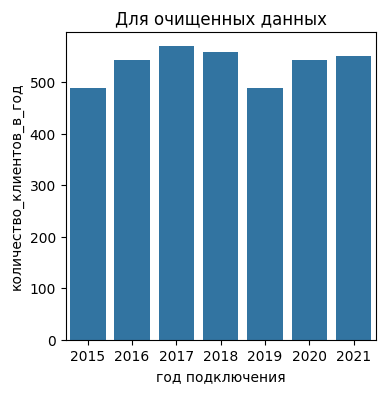

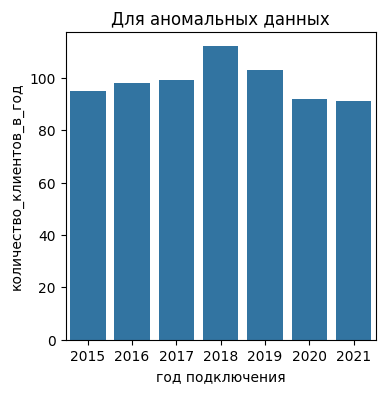

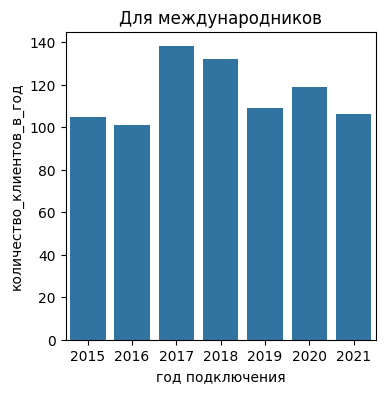

In [23]:
# для очищенных данных
df_year_clients = (
            df_clients.groupby('год подключения')
            .agg(количество_клиентов_в_год=('возраст', 'count'))
            .reset_index())

plt.figure(figsize=(4,4))
sns.barplot(x = df_year_clients['год подключения'],
            y = df_year_clients['количество_клиентов_в_год'])
plt.title('Для очищенных данных')
plt.show()

# для аномальных данных
df_year_anomals = (
            df_anomals.groupby('год подключения')
            .agg(количество_клиентов_в_год=('возраст', 'count'))
            .reset_index())

df_year_anomals
plt.figure(figsize=(4,4))
sns.barplot(x = df_year_anomals['год подключения'],
            y = df_year_anomals['количество_клиентов_в_год'])
plt.title('Для аномальных данных')
plt.show()

# для международников
df_year_country = (
            df_country.groupby('год подключения')
            .agg(количество_клиентов_в_год=('возраст', 'count'))
            .reset_index())

df_year_country
plt.figure(figsize=(4,4))
sns.barplot(x = df_year_country['год подключения'],
            y = df_year_country['количество_клиентов_в_год'])
plt.title('Для международников')
plt.show()


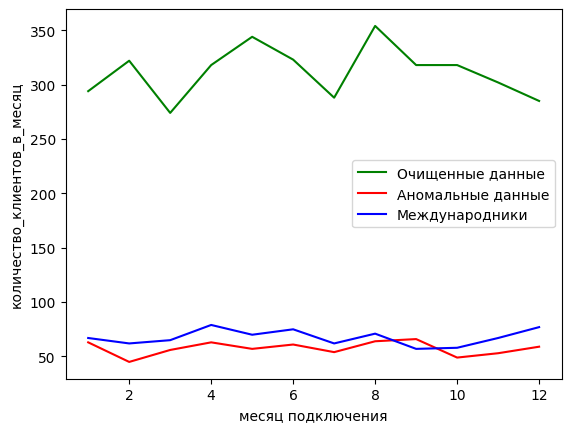

In [24]:
# динамика подключения по месяцам

# для очищенных данных
df_monthly_clients = (
            df_clients.groupby('месяц подключения')
            .agg(количество_клиентов_в_месяц=('возраст', 'count'))
            .reset_index())


ax = sns.lineplot(x = df_monthly_clients['месяц подключения'],
            y = df_monthly_clients['количество_клиентов_в_месяц'],
                  color='green',
                  label='Очищенные данные')

# для аномальных данных
df_monthly_anomals = (
            df_anomals.groupby('месяц подключения')
            .agg(количество_клиентов_в_месяц=('возраст', 'count'))
            .reset_index())

ax = sns.lineplot(x = df_monthly_anomals['месяц подключения'],
            y = df_monthly_anomals['количество_клиентов_в_месяц'],
                  color='red',
                  label='Аномальные данные')

# для международников
df_monthly_country = (
            df_country.groupby('месяц подключения')
            .agg(количество_клиентов_в_месяц=('возраст', 'count'))
            .reset_index())

ax = sns.lineplot(x = df_monthly_country['месяц подключения'],
            y = df_monthly_country['количество_клиентов_в_месяц'],
                  color='blue',
                  label='Международники')


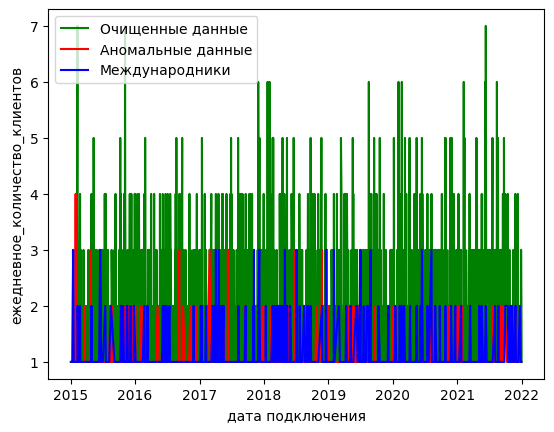

In [25]:
# динамика подключения по дням

# для очищенных данных
df_day_clients = (
            df_clients.groupby('дата подключения')
            .agg(ежедневное_количество_клиентов=('возраст', 'count'))
            .reset_index())


ax = sns.lineplot(x = df_day_clients['дата подключения'],
                  y = df_day_clients['ежедневное_количество_клиентов'],
                  color='green',
                  label='Очищенные данные')


# для аномальных данных
df_day_anomals = (
            df_anomals.groupby('дата подключения')
            .agg(ежеденевное_количество_клиентов=('возраст', 'count'))
            .reset_index())

ax = sns.lineplot(x = df_day_anomals['дата подключения'],
                  y = df_day_anomals['ежеденевное_количество_клиентов'],
                  color='red',
                  label='Аномальные данные')

# для международников
df_day_country = (
            df_country.groupby('дата подключения')
            .agg(ежеденевное_количество_клиентов=('возраст', 'count'))
            .reset_index())


ax = sns.lineplot(x = df_day_country['дата подключения'],
                  y = df_day_country['ежеденевное_количество_клиентов'],
                  color='blue',
                  label='Международники')

## Исследование объемов потребляемых услуг в разрезе признака "Статус"

In [26]:
# вычисление точечных оценок для объемов услуг для очищенных данных

lst_col = ['среднемесячный расход',
           'средняя продолжительность разговоров',
           'звонки днем', 'звонков вечером',
           'звонков ночью', 'звонки в другие города',
           'доля звонков на стационарные телефоны',
           'количество смс', 'звонки в другие страны']
# для очищенных данных
df_clients.groupby('статус')[lst_col].agg(['mean', 'median'])

среднемесячный расход         средняя продолжительность разговоров  \
                           mean  median                                 mean   
статус                                                                         
аспирант             407.093821  338.88                             3.974010   
бизнесмен            362.392457  307.49                             3.730785   
знаток               279.261575  196.00                             3.249420   
студент              174.276871  130.02                             2.505828   

                 звонки днем        звонков вечером        звонков ночью  \
          median        mean median            mean median          mean   
статус                                                                     
аспирант     3.5   57.676420   55.0       74.874355   72.0      1.693632   
бизнесмен    3.2   51.866816   53.0       66.096413   66.0      1.457399   
знаток       2.7   39.416252   42.0       50.290216   45.0      0.973466   
студент      2.3   34.165644   35.0       67.260736   70.0      5.049080   

                 звонки в другие города         \
          median                   mean median   
статус                                           
аспирант     1.0               9.199656    2.0   
бизнесмен    0.0               8.630942    2.0   
знаток       0.0               5.548922    0.0   
студент      6.0               0.460123    0.0   

          доля звонков на стационарные телефоны        количество смс         \
                                           mean median           mean median   
статус                                                                         
аспирант                              11.812392   11.0      26.698795   23.0   
бизнесмен                             10.564574   10.0      12.392377    4.0   
знаток                                 9.366501    7.0       2.451078    3.0   
студент                                3.552147    3.0      38.595092   36.0   

          звонки в другие страны         
                            mean median  
статус                                   
аспирант                0.323580    0.0  
бизнесмен               0.296413    0.0  
знаток                  0.197347    0.0  
студент                 0.067485    0.0

In [27]:
# для аномальных данных
df_anomals.groupby('статус')[lst_col].agg(['mean', 'median'])

среднемесячный расход          средняя продолжительность разговоров  \
                           mean   median                                 mean   
статус                                                                          
аспирант            1419.010000  1194.63                             8.775630   
бизнесмен           2069.064475  1765.65                             9.767580   
знаток              2527.150625  2463.18                             9.685417   
студент              331.162865   171.99                             3.378919   

                 звонки днем        звонков вечером        звонков ночью  \
          median        mean median            mean median          mean   
статус                                                                     
аспирант    8.40  136.201681  107.0      110.844538  115.0     45.050420   
бизнесмен   9.60  205.926941  163.0      107.748858  109.0     28.913242   
знаток      9.15  276.937500  276.5      107.354167  104.5     16.166667   
студент     2.60   44.448649   35.0       70.929730   70.0     18.600000   

                 звонки в другие города         \
          median                   mean median   
статус                                           
аспирант    39.0              16.281513    9.0   
бизнесмен   25.0              22.607306   15.0   
знаток      15.0              24.187500   26.5   
студент     17.0               2.091892    0.0   

          доля звонков на стационарные телефоны        количество смс         \
                                           mean median           mean median   
статус                                                                         
аспирант                              10.075630    8.0      67.294118   65.0   
бизнесмен                             18.086758   14.0      36.844749   12.0   
знаток                                26.750000   24.5       6.562500    6.5   
студент                                4.827027    4.0      65.589189   72.0   

          звонки в другие страны         
                            mean median  
статус                                   
аспирант                0.987395    0.0  
бизнесмен               1.648402    0.0  
знаток                  2.729167    0.0  
студент                 0.189189    0.0

In [28]:
# для международников
df_country.groupby('статус')[lst_col].agg(['mean', 'median'])

среднемесячный расход          средняя продолжительность разговоров  \
                           mean   median                                 mean   
статус                                                                          
аспирант             807.884396  492.665                             5.437363   
бизнесмен            695.198424  410.100                             4.910303   
знаток               870.624731  397.300                             5.110753   
студент              326.308500  131.095                             2.992500   

                 звонки днем        звонков вечером        звонков ночью  \
          median        mean median            mean median          mean   
статус                                                                     
аспирант    4.25   96.725275   67.0       87.181319   86.0     17.346154   
бизнесмен   3.90   84.715152   59.0       78.597980   79.0      5.696970   
знаток      4.00  107.225806   61.0       82.322581   82.0      5.602151   
студент     2.30   54.000000   36.0       67.350000   66.5     12.975000   

                 звонки в другие города         \
          median                   mean median   
статус                                           
аспирант     4.0              14.236264    7.0   
бизнесмен    1.0              12.292929    4.0   
знаток       2.0              11.935484    4.0   
студент      9.0               1.650000    0.0   

          доля звонков на стационарные телефоны        количество смс         \
                                           mean median           mean median   
статус                                                                         
аспирант                              12.038462   11.0      37.368132   25.0   
бизнесмен                             13.317172   12.0      17.072727    5.0   
знаток                                16.118280   15.0       3.989247    4.0   
студент                                5.250000    4.5      45.350000   39.5   

          звонки в другие страны         
                            mean median  
статус                                   
аспирант                2.324176    2.0  
бизнесмен               2.064646    2.0  
знаток                  2.688172    2.0  
студент                 1.425000    1.0

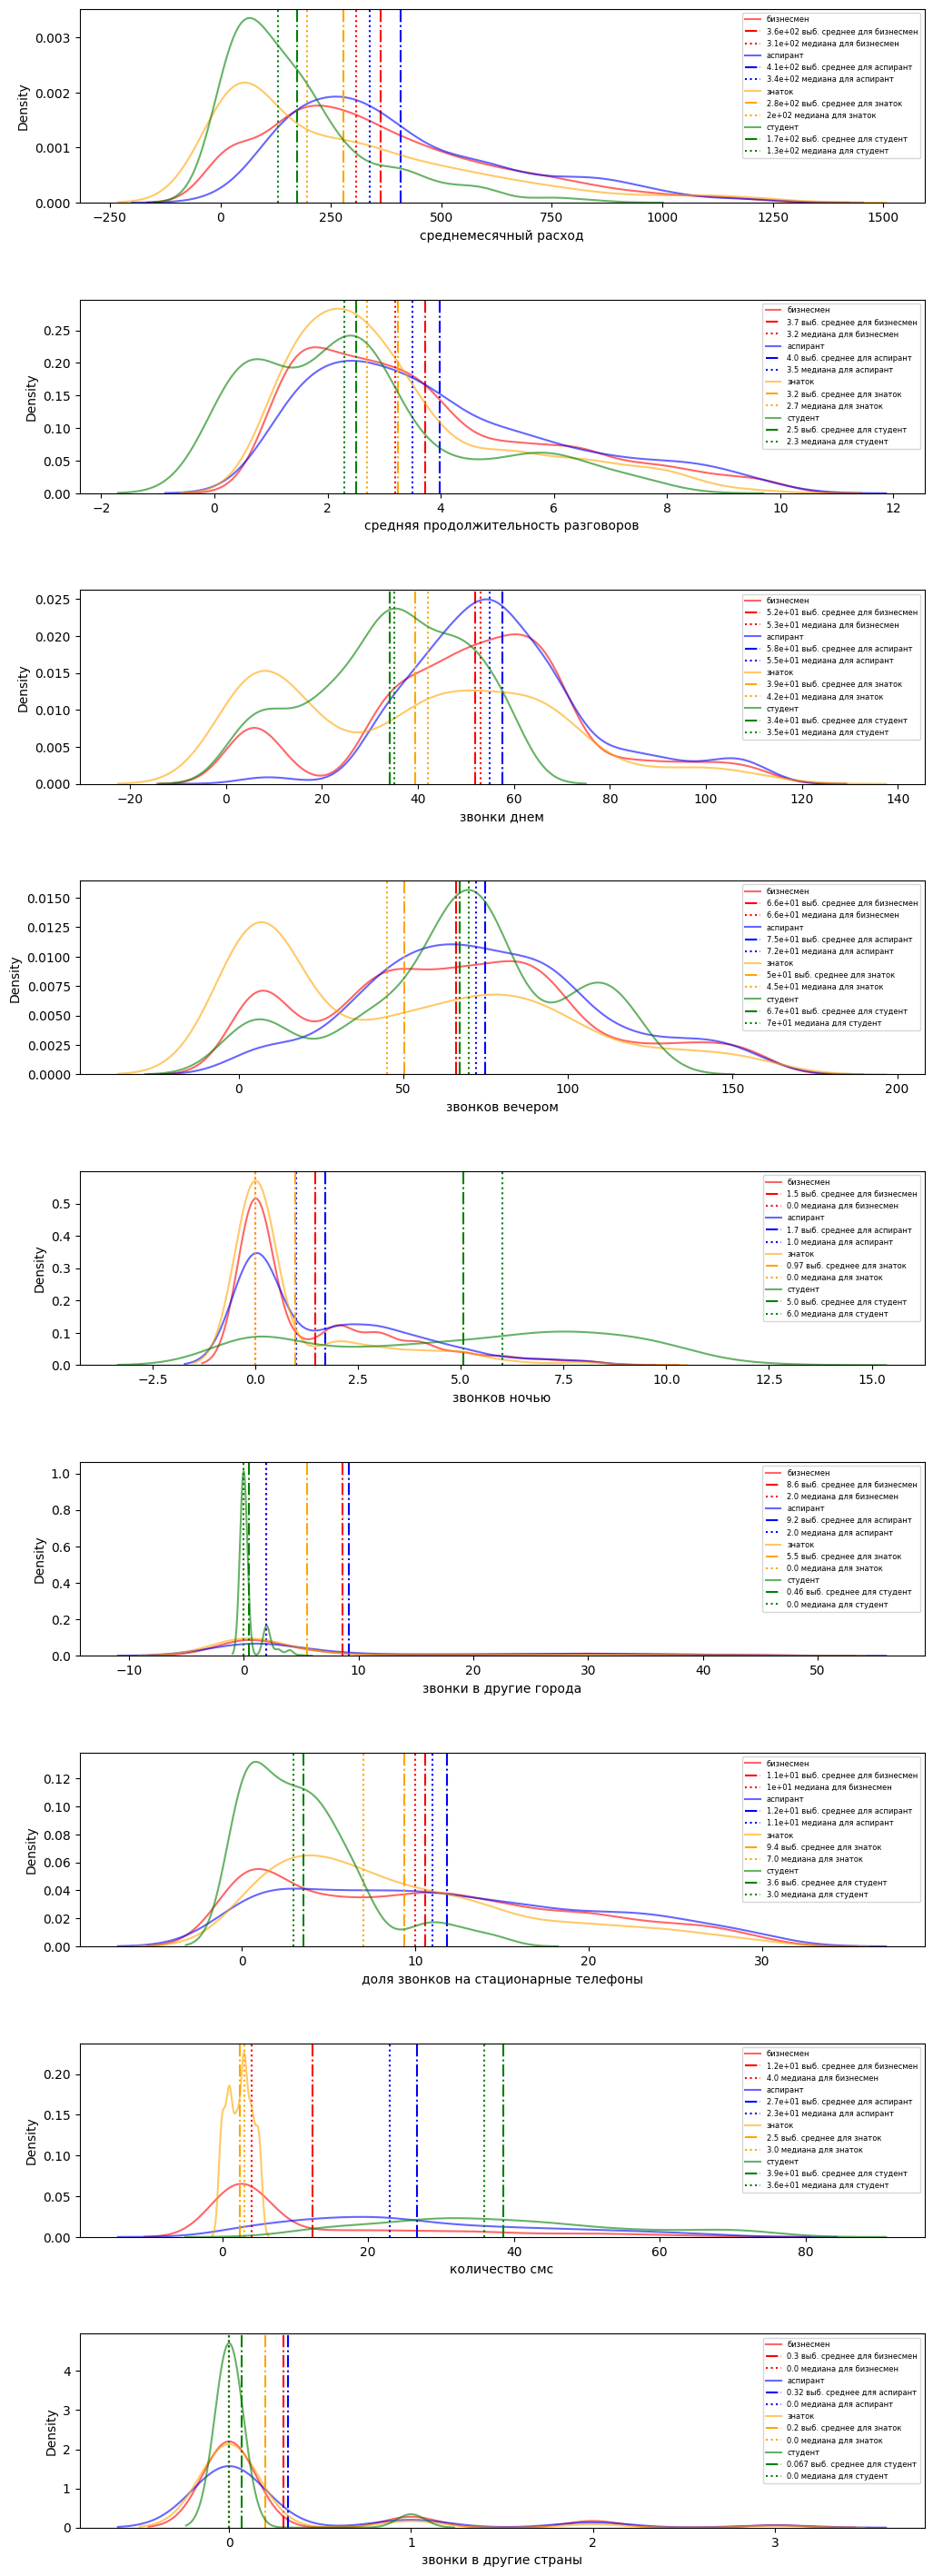

In [29]:
# визуализация распределения значений по заданным признакам

plt.subplots(9,1, figsize=(12,36), gridspec_kw = {'wspace': 0.5,
                                                 'hspace': 0.5})
dct_color = {'студент': 'green',
             'аспирант': 'blue',
             'бизнесмен': 'red',
             'знаток': 'orange'}

for index_fig, col in enumerate(lst_col, start=1):
    plt.subplot(9,1, index_fig)
    for client_status in df_clients['статус'].unique():
        ser_temp = df_clients[df_clients['статус'] == client_status][col]

        ax = sns.kdeplot(ser_temp,
             color=dct_color.get(client_status),
             label=f'{client_status}',
                  alpha=0.6)
        ax.axvline(ser_temp.mean(),
           color=dct_color.get(client_status),
           label=f'{ser_temp.mean():.2} выб. среднее для {client_status}',
           linestyle='-.')
        ax.axvline(ser_temp.median(),
           color=dct_color.get(client_status),
           label=f'{ser_temp.median():.2} медиана для {client_status}',
           linestyle=':')
        plt.legend(fontsize=6)

## Выводы

- для исследования выделены 3 набора данных:
набор очищенных данных; набор аномальных; данные клиентов, пользующихся услугами международной связи;
- исследовано распределение кол-ва подключений клиентов по годам/месяцам/дням.
Установлено, что по годам и месяцам не наблюдается какая-либо ярко выраженная тенденция.

Для клиентов с аномальными записями и международников наблюдается тенденция к увеличению. По другим клиентам, наоборот, к их уменьшению.
Возможно, это связано с повышением привлекательности соответствующих услуг.

- усредненные объемы потребляемых услуг для очищенных данных:
   - среднемесячный расход: студенты тратят значительно меньше других категорий; знатоки тратят больше студентов, но меньше аспирантов и бизнесменов; бизнесмены и аспиратны тратят примерно одинаково;
   - днем чаще всего звонят аспиранты и бизнесмены, а вечером и ночью - студенты;
   - в другие города студенты почти не звонят, в отличие от остальных категорий;
   - смс отправляют чаще студенты и аспиранты.
- усредненные объемы для аномальных данных:
   - среднемесячный расход у бизнесменов и знатоков не сильно отличается;
   - звонков днем, ночью и вечером меньше всего совершали студенты;
   - смс отправляли больше всех студенты.
- усредненные объемы для клиентов, потребляющих услуги международной связи:
   - больше всех тратили на связь знатоки и аспиранты;
   - по количеству звонков лидируют знатоки и аспиранты;
   - смс чаще использовали также студенты и аспиранты.


## Диаграммы рассеивания

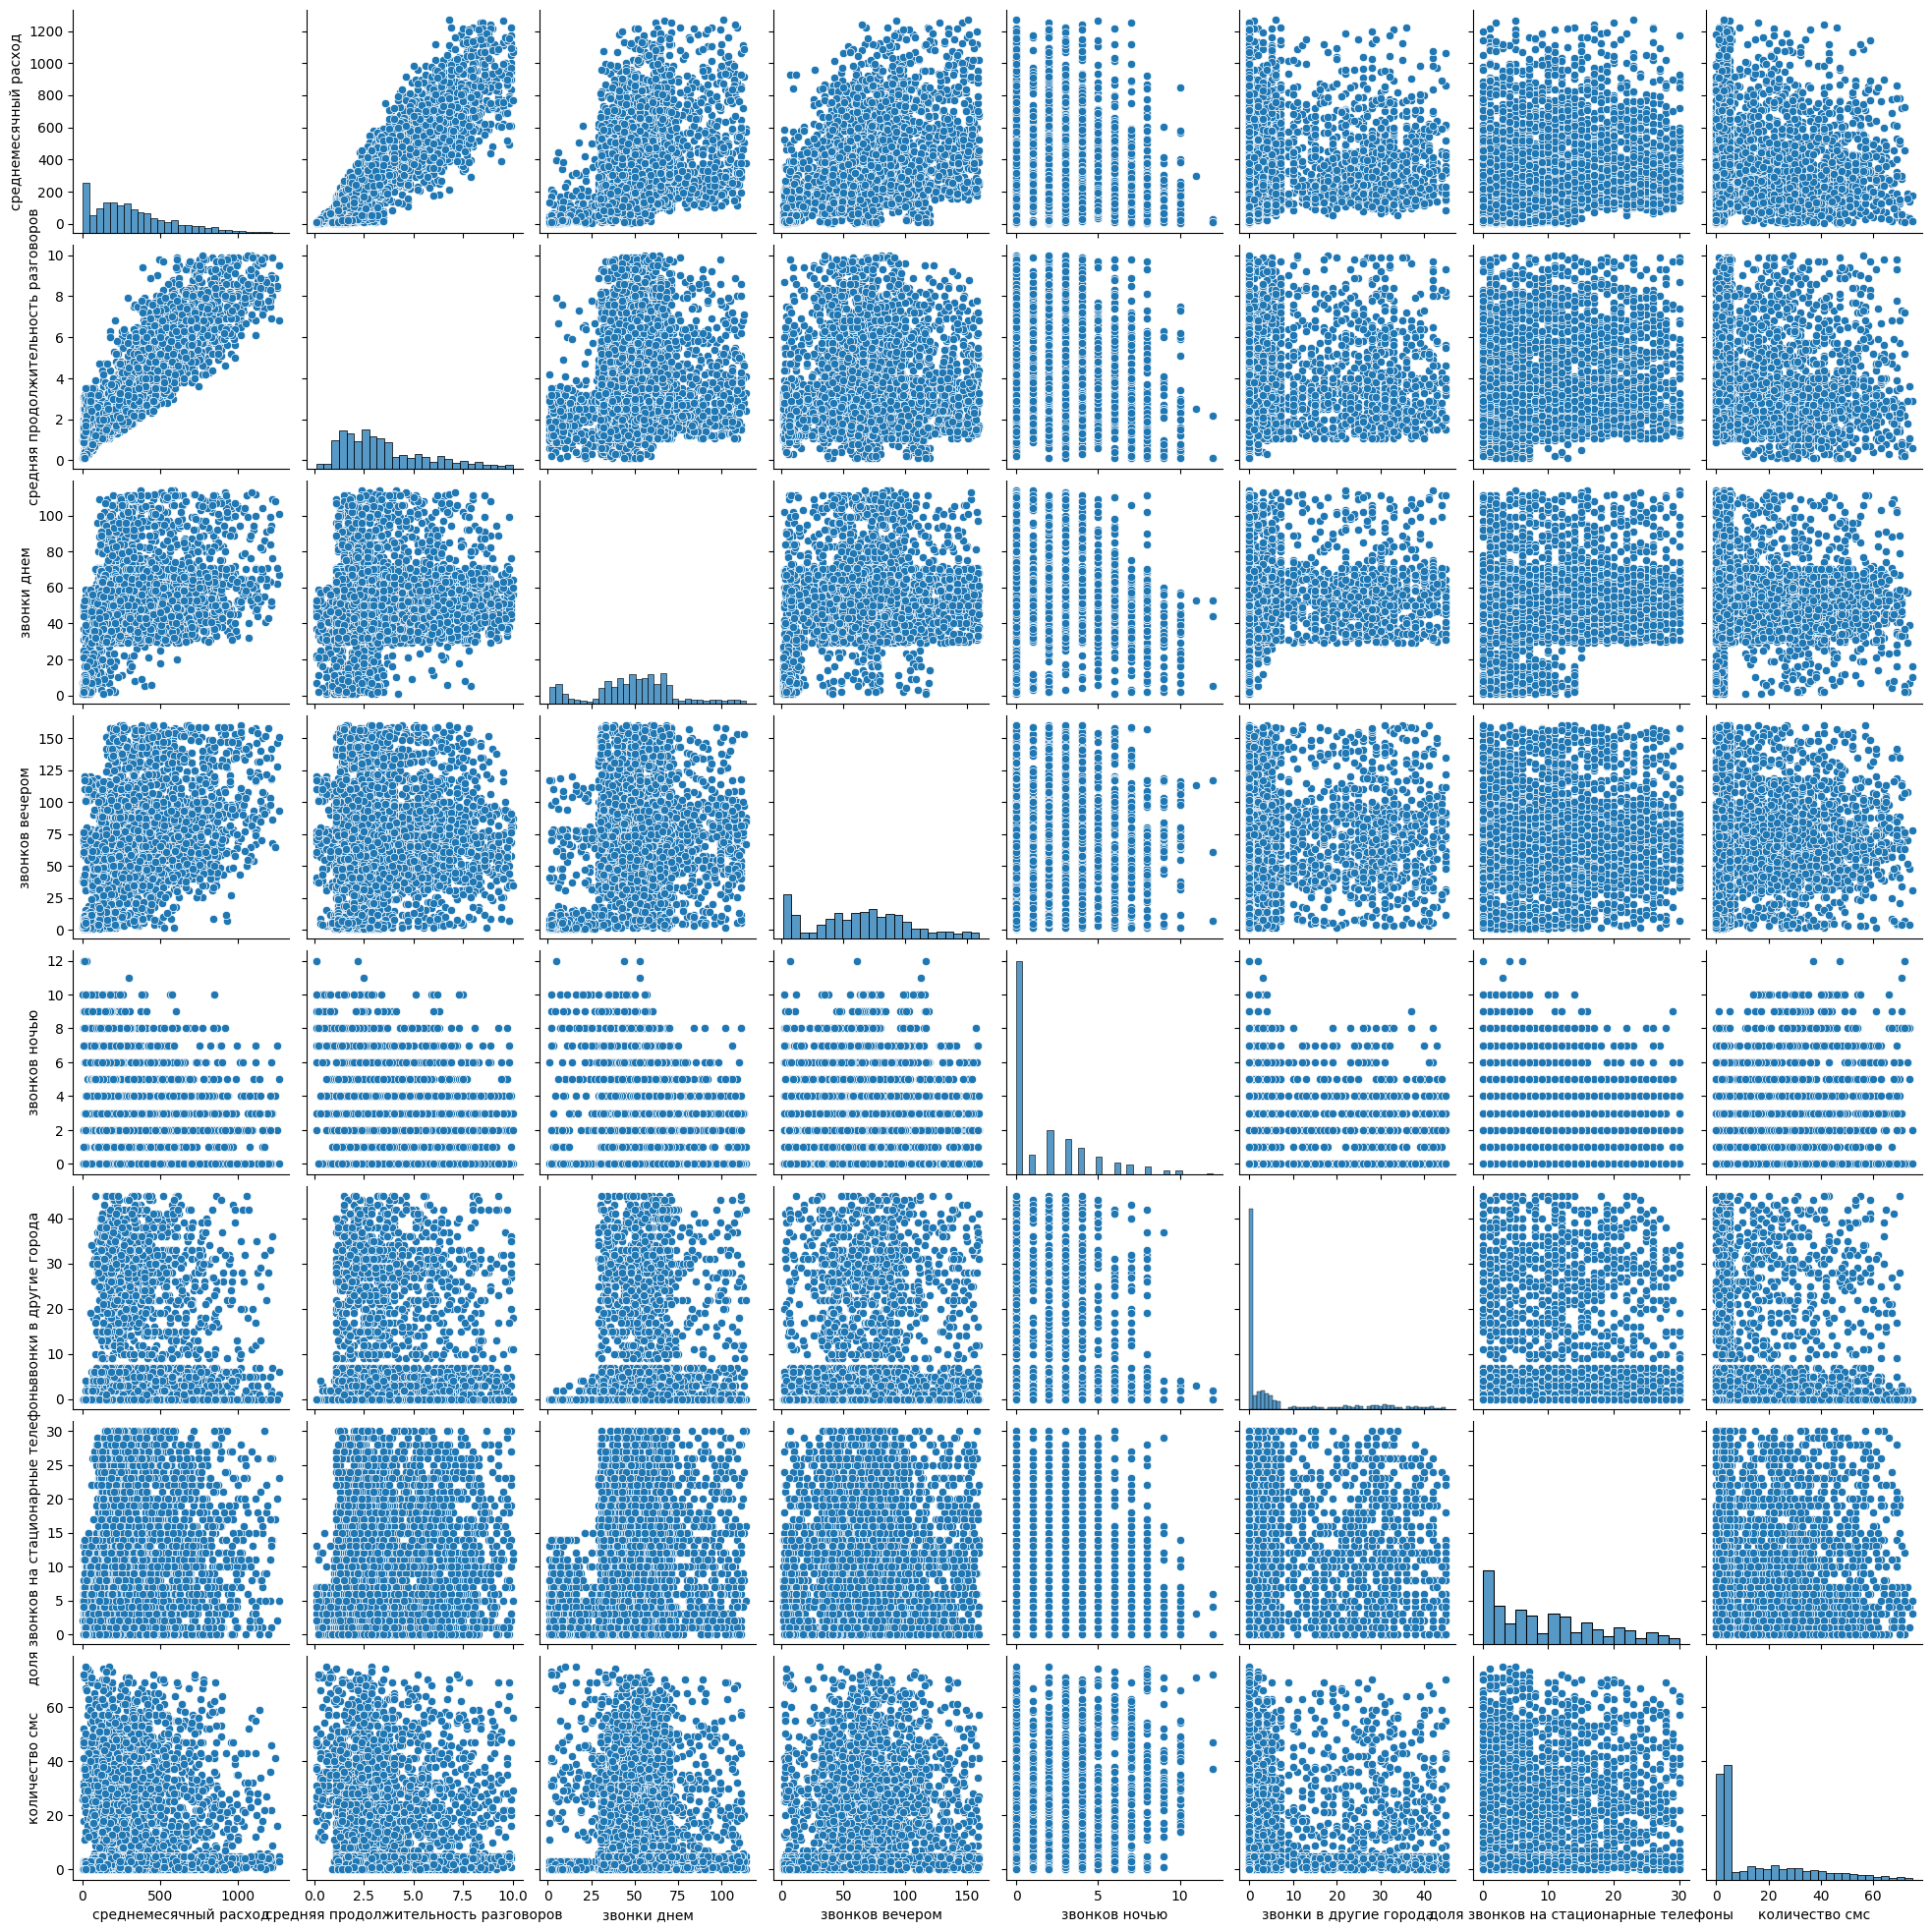

In [30]:
lst_cols = ['среднемесячный расход',
       'средняя продолжительность разговоров', 'звонки днем',
       'звонков вечером', 'звонков ночью',
       'звонки в другие города',
       'доля звонков на стационарные телефоны',
       'количество смс']
sns.pairplot(df_clients[lst_cols])

In [31]:
# корреляция
from scipy.stats import pearsonr

pearsonr(df_clients['среднемесячный расход'], df_clients['средняя продолжительность разговоров'])


PearsonRResult(statistic=np.float64(0.8756701030234647), pvalue=np.float64(0.0))

In [32]:

df_clients[lst_cols].corr()

среднемесячный расход  \
среднемесячный расход                               1.000000   
средняя продолжительность разговоров                0.875670   
звонки днем                                         0.504357   
звонков вечером                                     0.515606   
звонков ночью                                       0.005598   
звонки в другие города                              0.154082   
доля звонков на стационарные телефоны               0.230114   
количество смс                                      0.042993   

                                       средняя продолжительность разговоров  \
среднемесячный расход                                              0.875670   
средняя продолжительность разговоров                               1.000000   
звонки днем                                                        0.251627   
звонков вечером                                                    0.189235   
звонков ночью                                                     -0.003808   
звонки в другие города                                             0.119744   
доля звонков на стационарные телефоны                              0.172943   
количество смс                                                     0.030141   

                                       звонки днем  звонков вечером  \
среднемесячный расход                     0.504357         0.515606   
средняя продолжительность разговоров      0.251627         0.189235   
звонки днем                               1.000000         0.368604   
звонков вечером                           0.368604         1.000000   
звонков ночью                             0.043283         0.104627   
звонки в другие города                    0.203533         0.143106   
доля звонков на стационарные телефоны     0.289116         0.207995   
количество смс                            0.115420         0.149829   

                                       звонков ночью  звонки в другие города  \
среднемесячный расход                       0.005598                0.154082   
средняя продолжительность разговоров       -0.003808                0.119744   
звонки днем                                 0.043283                0.203533   
звонков вечером                             0.104627                0.143106   
звонков ночью                               1.000000               -0.020127   
звонки в другие города                     -0.020127                1.000000   
доля звонков на стационарные телефоны      -0.042589                0.137179   
количество смс                              0.220876                0.023018   

                                       доля звонков на стационарные телефоны  \
среднемесячный расход                                               0.230114   
средняя продолжительность разговоров                                0.172943   
звонки днем                                                         0.289116   
звонков вечером                                                     0.207995   
звонков ночью                                                      -0.042589   
звонки в другие города                                              0.137179   
доля звонков на стационарные телефоны                               1.000000   
количество смс                                                      0.024817   

                                       количество смс  
среднемесячный расход                        0.042993  
средняя продолжительность разговоров         0.030141  
звонки днем                                  0.115420  
звонков вечером                              0.149829  
звонков ночью                                0.220876  
звонки в другие города                       0.023018  
доля звонков на стационарные телефоны        0.024817  
количество смс                               1.000000

###Вывод
По диаграмме рассеивания установлена зависимость между признаками "среднемесячный расход" и "средняя продолжительность разговоров".

# Сегментация клиентов: кластерный анализ

In [33]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import MinMaxScaler

In [34]:
# нормализация данных
lst_cols = ['возраст', 'среднемесячный расход',
       'средняя продолжительность разговоров', 'звонки днем',
       'звонков вечером', 'звонков ночью',
       'звонки в другие города',
       'доля звонков на стационарные телефоны',
       'количество смс']
X = df_clients[lst_cols]


In [35]:
sc = MinMaxScaler()
sc.fit(X)
X_scaler = sc.transform(X)

In [36]:
X_scaler;

In [37]:
# расчет матрицы кластеризации
z = linkage(X_scaler,
            method='ward',
            metric='euclidean')

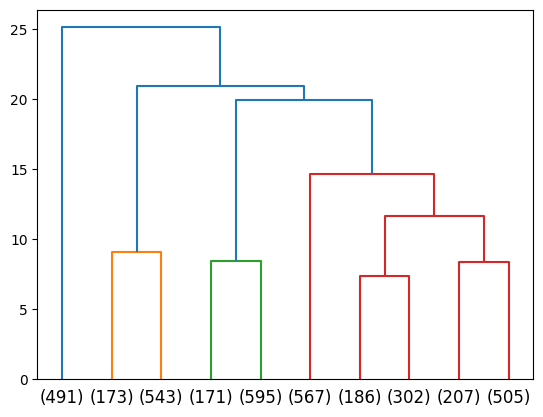

In [38]:
dendrogram(z,
           p=10,
           truncate_mode ='lastp'
           );

In [39]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [40]:
c, coph_dists = cophenet(z, pdist(X_scaler))
c

np.float64(0.5100945372261114)

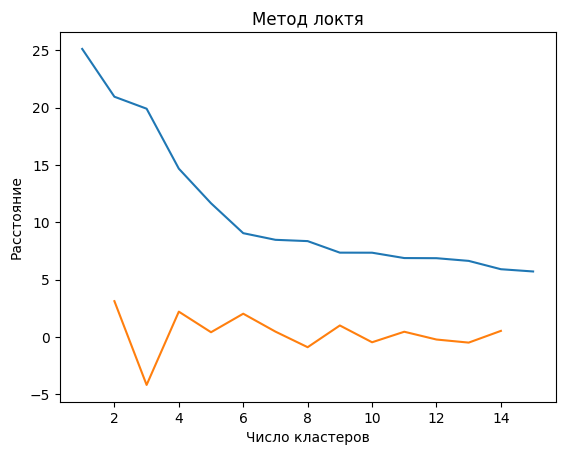

clusters: 2


In [41]:
last = z[-15:, 2] # в матрице связей берем последние 20 значений расстояний между кластерами
last_rev = last[::-1] #переписываем в обратном порядке
idxs = np.arange(1, len(last) + 1,1) #генерируем список начальное значение 1, конечное --- число элементов массива, шаг 1
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev) #отображение графика

#далее идет расчет вторых разностей
acceleration = np.diff(last, 2) #расчет вторых разностей
acceleration_rev = acceleration[::-1] #переписываем в обратном порядке
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("clusters:", k)

In [42]:
# разбиение на кластеры и присвоение меток

df_clients['number_cluster'] = fcluster(z, t=4, criterion='maxclust')

/tmp/ipython-input-1935181101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clients['number_cluster'] = fcluster(z, t=4, criterion='maxclust')


In [43]:
# анализ кластеризации
df_clients.groupby('number_cluster')[lst_cols].agg(['mean', 'median'])

возраст        среднемесячный расход          \
                     mean median                  mean  median   
number_cluster                                                   
1               55.356415   54.0             27.114134   20.25   
2               27.881285   26.0            236.144930  211.36   
3               43.620104   44.0            395.105705  336.87   
4               46.369553   47.0            444.155008  375.96   

               средняя продолжительность разговоров        звонки днем         \
                                               mean median        mean median   
number_cluster                                                                  
1                                          1.798676    1.7    7.743381    6.0   
2                                          2.815922    2.5   45.627095   45.0   
3                                          3.954308    3.5   55.677546   55.0   
4                                          4.231183    3.7   59.399547   57.0   

               звонков вечером        звонков ночью         \
                          mean median          mean median   
number_cluster                                               
1                     6.122200    5.0      0.122200    0.0   
2                    68.210894   69.0      3.456704    3.0   
3                    74.126632   72.0      1.609661    0.0   
4                    76.130730   74.0      1.527448    0.0   

               звонки в другие города         \
                                 mean median   
number_cluster                                 
1                            0.008147    0.0   
2                            1.289106    0.0   
3                           29.472585   30.0   
4                            2.594793    0.0   

               доля звонков на стационарные телефоны        количество смс  \
                                                mean median           mean   
number_cluster                                                               
1                                           2.892057    0.0       0.763747   
2                                           5.368715    4.0      35.033520   
3                                          11.558747   11.0      16.305483   
4                                          13.078664   12.0      10.898698   

                       
               median  
number_cluster         
1                 0.0  
2                33.0  
3                 5.0  
4                 4.0

## Выводы
- в ходе выполнения задачи кластеризации клиенты были разбиты на 4 кластера:
     |кластер|особенности|
     |--:|:--|
     |1 - | средний возраст - 55, реже остальных кластеров пользуются услугами связи,|
     ||почти не звонят ночью, в другие города, и не отправляют смс. Можно отнести этот кластер к "знатокам"|
     |2 - |средний возраст - 27, чаще звонят ночью и чаще остальных отправляют смс. Можно отнести этот кластер к "аспирантам".|
     |3 - |средний возраст - 44, чаще пользуются связью чем 1 и 2 кластер, основная особенность - намного чаще остальных звонят в другие города.|
     ||Сюда можно отнести "бизнесменов".|
     |4 - |средний возраст - 47, больше всех пользуются связью, но редко звонят в другие города. Сюда тоже отнесем "бизнесменов".|

# Статистические гипотезы

In [44]:
df_clients.groupby('number_cluster')['среднемесячный расход'].mean()

number_cluster
1     27.114134
2    236.144930
3    395.105705
4    444.155008
Name: среднемесячный расход, dtype: float64

## Формулировка гипотез
 Так как средние значения клиентов 3 и 4 кластера не сильно отличаются, следует проверить гипотезы:

- признак `среднемесячный расход`
    - H_0 -- клиенты кластера 3, не имеют статистически значимых различий с клиентами кластера 4 в потреблении услуг связи;
    - H_1 (двусторонняя) -- клиенты кластера 3, имеют статистически значимые различия с клиентами кластера 4 в потреблении услуг связи.

In [45]:
# формируем выборки - случайные величины - для проверки нормальности распределения

# первая выборка -- клиенты 3 кластера -- закон распределения F(x)
x = df_clients[df_clients['number_cluster'] == 3]['среднемесячный расход']

# вторая выборка -- клиенты  4 кластера-- закон распределения F(y)
y = df_clients[df_clients['number_cluster'] == 4]['среднемесячный расход']

In [46]:
# проверяем гипотезу о нормальности исследуемых случайных величин:

# H_0: распределения случайных исследуемых величин не отличаются от нормального
# H_1: распределения случайных исследуемых величин отличны от нормального

check_hyp(x)


Критерий Шапиро
Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = 1.1683335591826689e-20


In [47]:
check_hyp(y)

Критерий Шапиро
Гипотезу H_0 о нормальном распределении x отвергаем.
        Иными словами, распределение сл. величины x отлично от нормального.
        p-value = 1.653636804472343e-27


In [48]:
check_ks(x)

Критерий Колмогорова-Смирнова
Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = 0.7911777488048676


In [49]:
check_ks(y)

Критерий Колмогорова-Смирнова
Гипотезу H_0 о нормальном распределении x принимаем.
        Иными словами, распределение сл. величины x нормальное.
        p-value = 0.7728501671573519


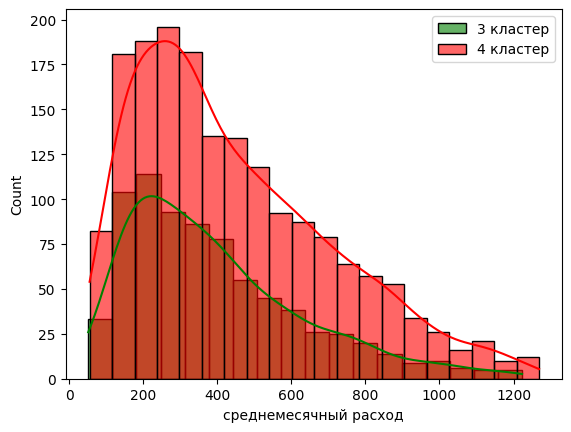

In [50]:
# так как при проверке гипотезы о нормальном распределении результаты отличаются
# по двум критериям, построим графики распределения:

sns.histplot(data=df_clients[df_clients['number_cluster'] == 3],
             x='среднемесячный расход',
             color='green',
             alpha=0.6,
             kde=True,
             label='3 кластер')
sns.histplot(data=df_clients[df_clients['number_cluster'] == 4],
             x='среднемесячный расход',
             color='red',
             alpha=0.6,
             kde=True,
             label='4 кластер')
plt.legend()

Глядя на графики распределения величин по признаку `среднемесячный расход` можно сделать вывод,
что распределение является нормальным, поэтому для проверки гипотезы по параметрам, следует воспользоваться критерием Стъюдента.


In [51]:
check_ttest(x,y)

Статистика t-теста: 0.09692565026648994
P-значение: 7.953764673720334e-05
Критерий Стъюдента
Различия статистически значимы (принимаем альтернативную гипотезу):
      <<<клиенты кластера 3, имеют статистически значимые различия
      с клиентами кластера 4 в потреблении услуг связи>>>
        p-value = 7.953764673720334e-05


## Вывод по результатам проверки гипотез:
- клиенты кластера 3 и 4 имеют значимые различия в потреблении услуг связи, хоть и средние значения у них близки друг к другу. Это означает, что сегментация на 4 кластера была проведена корректно.

# Результат исследования

* Было выделено 3 набора данных: набор очищенных данных; набор данных с аномальными записями; данные клиентов, пользующихся услугами международной связи;

* Для набора с очищенными данными, установлено, что распределение кол-ва подключений клиентов по годам и месяцам не имеет ярко выраженных тенденций. У остальных наборов данных, наоборот, имеется тенденция к увеличению кол-ва подключений;

* В разрезе признака Возрастная категория, выявлено, что меньше всех тратят на связь «Студенты», а больше всех «Бизнесмены» и «Аспиранты»;

* В ходе кластерного анализа, клиенты были распределены на 4 кластера:
   - 1 кластер (средний возраст - 55 лет) – реже остальных пользуются услугами связи;
   - 2 кластер (средний возраст – 27 лет) – чаще звонят ночью и чаще отправляют СМС;
   - 3 кластер (средний возраст – 44 года) – чаще пользуются связью и больше всех звонят в другие города;
   - 4 кластер (средний возраст – 47 лет) – пользуются связью наравне с 3 кластером, но не звонят в другие города;
* При проверке гипотез было установлено, что клиенты кластеров 3 и 4 имеют значимые различия в потреблении услуг связи, хоть и средние значения у них близки друг к другу.

**Рекомендации:**

* Для выделенных групп клиентов для стимулирования большего потребления услуг связи предлагаю:
 - для клиентов 1 кластера, которые меньше всех пользуются звонками и смс – разработать акционный тариф «говоришь больше, платишь меньше»;
 - для клиентов 2 кластера – разработать тариф с безлимитным пакетом СМС;
 - для клиентов 3 кластера, которые и так много тратят на связь, увеличить количество бесплатных минут для междугородних звонков;
 - для клиентов 4 кластера, которые также много тратят на связь, можно немного поднять стоимость тарифа, и предложить бесплатные услуги, например, «защита от мошенников».